In [14]:
from tqdm.notebook import tqdm
import os

## Загрузка датасета

In [15]:
data = []
for folder in os.listdir('kinopoisk'):
    if not folder.startswith('.'):
        for file in os.listdir(f'kinopoisk/{folder}'):
            with open(f'kinopoisk/{folder}/{file}') as f:
                record = {
                       'sentiment': folder,
                       'text': f.read()
                }
                data += [record]

In [16]:
len(data)

3000

In [17]:
data[0]

{'sentiment': 'positive',
 'text': "Примерно год назад я на сайте кинопоиск обнаружил страницу, посвященную некоему сериалу 'Игра престолов', в котором главную роль должен был исполнить знаменитый актёр Шон Бин. Первоначально просмотрев описание, я решил что это будет типичный средневековый 'сериальчик' вроде 'Мерлина' и всего прочего, из всех фентезийных сериалов мне больше всего запомнился как раз таки 'Мерлин' с Сэмом Нилом, и то он не воспринимался так мощно, как этого бы хотелось.\n\n\nНу вот 18 апреля я посмотрел первую серию 'Игры престолов', и меня словно молния ударила (в Положительном смысле). Очень поразило то, насколько создатели качественно и серьезно отнеслись к созданию сериала. Декорации, спецэффекты, актерский состав поразили меня, ведь для телевизионного формата эта экранизация книги просто великолепна. После первой серии я с нетерпением ждал каждой следующий и попутно даже стал читать книгу.\n\n\nГоворя об актерах, очень понравился в 'Игре' Шон Бин. Я его открыл для 

## Предобработка текстов 

In [18]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [ ]:
prep_data = []
for record in tqdm(data):
    if 'sentiment' not in record:
        continue
    
    prep_tokens = []
    for word in record['text'].split():
        cleaned_word  = ''
        for character in word.lower():
            if character in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя-':
                cleaned_word += character
            elif character == '!':
                prep_tokens += ['!']
        if cleaned_word != '':
            prep_tokens += [morph.parse(cleaned_word)[0].normal_form]

    prep_record = {
        'sentiment': record['sentiment'],
        'text': ' '.join(prep_tokens)
    }
    prep_data += [prep_record]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
prep_data[0]

In [ ]:
len(prep_data)

## Анализ экспрессивов и регрессионная модель

In [ ]:
negative_set = []
neutral_set = []
positive_set = []

for record in prep_data:
    if record['sentiment'] == 'negative':
        negative_set += [record['text']]
    elif record['sentiment'] == 'neutral':
        neutral_set += [record['text']]
    else:
        positive_set += [record['text']]
len(negative_set), len(neutral_set), len(positive_set)

In [ ]:
import numpy as np

WORD = 'жаль'

logodds = []
for subset in [negative_set, neutral_set, positive_set]:
    word_freq = 0
    for text in subset:
        for word in text.split():
            if WORD == word:
                word_freq += 1
    
    subset_len = 0
    for text in subset:
        subset_len += len(text)

    logodds += [np.log(word_freq / (subset_len - word_freq))]

In [ ]:
for text in subset:
    for word in text.split():
        if word == 'жаль':
            print(text)
            break

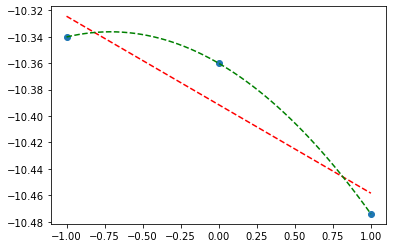

In [13]:
import matplotlib.pyplot as plt

sentiment = [-1, 0, 1]

k, b = np.polyfit(sentiment, logodds, 1)
y_reg_lin = []
for x in sentiment:
    y_reg_lin += [k * x + b]

a, b, c = np.polyfit(sentiment, logodds, 2)

parabolic_x = np.linspace(-1, 1)
y_reg_parabolic = []
for x in parabolic_x:
    y_reg_parabolic += [a * x ** 2 + b * x + c]

plt.scatter(sentiment, logodds)
plt.plot(sentiment, y_reg_lin, 'r--')
plt.plot(parabolic_x, y_reg_parabolic, 'g--')
plt.show()